# Hyperparameters and lags search: backtesting vs one-step-ahead

Hyperparameter and lag tuning involves systematically testing different values or combinations of hyperparameters (and/or lags) to find the optimal configuration that gives the best performance. The **skforecast** library provides two different methods to evaluate each candidate configuration:

+ **Backtesting**: In this method, the model predicts several steps ahead in each iteration, using the same forecast horizon and retraining frequency strategy that would be used if the model were deployed. This simulates a real forecasting scenario where the model is retrained and updated over time. More information [here](../user_guides/backtesting.html).

+ **One-Step Ahead**: Evaluates the model using only one-step-ahead predictions. This method is faster because it requires fewer iterations, but it only tests the model's performance in the immediate next time step ($t+1$).

Each method uses a different evaluation strategy, so they may produce different results. However, in the long run, both methods are expected to converge to similar selections of optimal hyperparameters. The one-step-ahead method is much faster than backtesting because it requires fewer iterations, but it only tests the model's performance in the immediate next time step. It is recommended to backtest the final model for a more accurate multi-step performance estimate.

The document compares the performance of these two methods when applied to various datasets and forecaster types. The process is outlined as follows:

+ Optimal hyperparameters and lags are identified through a search using both backtesting and one-step-ahead evaluation methods. This search is performed on the validation partition, and the best configuration is stored along with the time taken to complete the search.

+ Finally, the selected best configuration is evaluated on the test partition using a backtesting procedure.

It is important to note that the final evaluation is consistently performed using backtesting to simulate a real-world multi-step forecasting scenario.

## Results

The results show a significant reduction in the time required to find the optimal configuration using the one-step-ahead method (top panel). However, the performance of the selected configuration on the test partition is similar for both methods (lower panel), with no clear winner. These results are consistent for both grid search and Bayesian search approaches.

<div style="text-align: center;">
    <img src="../img/grid_search_benchmarck.png" alt="Grid Search Results" width="700"/>
</div>

<div style="text-align: center;">
    <img src="../img/bayesian_search_benchmarck.png" alt="Grid Search Results" width="700"/>
</div>

<div class="admonition note" name="html-admonition" style="background: rgba(0,184,212,.1); padding-top: 0px; padding-bottom: 6px; border-radius: 8px; border-left: 8px solid #00b8d4; border-color: #00b8d4; padding-left: 10px; padding-right: 10px;">

<p class="title">
    <i style="font-size: 18px; color:#00b8d4;"></i>
    <b style="color: #00b8d4;">&#9998 Note</b>
</p>

The purpose of this analysis is to compare the time and forecasting performance of the two available evaluation methods, not to compare different forecasters.

</div>

## Libraries

In [24]:
# Libraries
# ==============================================================================
import platform
import psutil
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from time import time
from copy import copy
import sklearn
import skforecast
import lightgbm
from lightgbm import LGBMRegressor
from sklearn.linear_model import Ridge
from sklearn.preprocessing import StandardScaler
from skforecast.datasets import fetch_dataset
from skforecast.plot import set_dark_theme
from skforecast.recursive import ForecasterRecursive
from skforecast.direct import ForecasterDirect
from skforecast.model_selection import TimeSeriesFold, OneStepAheadFold
from skforecast.model_selection import grid_search_forecaster
from skforecast.model_selection import bayesian_search_forecaster
from skforecast.model_selection import backtesting_forecaster
from skforecast.recursive import ForecasterRecursiveMultiSeries
from skforecast.direct import ForecasterDirectMultiVariate
from skforecast.model_selection import backtesting_forecaster_multiseries
from skforecast.model_selection import grid_search_forecaster_multiseries
from skforecast.model_selection import bayesian_search_forecaster_multiseries
from skforecast.preprocessing import series_long_to_dict
from skforecast.preprocessing import exog_long_to_dict

# Warnings
# ==============================================================================
import warnings
from skforecast.exceptions import IgnoredArgumentWarning
warnings.filterwarnings('ignore')
warnings.simplefilter('ignore', category=IgnoredArgumentWarning)

In [25]:
# Versions
# ==============================================================================
print(f"Python version      : {platform.python_version()}")
print(f"scikit-learn version: {sklearn.__version__}")
print(f"skforecast version  : {skforecast.__version__}")
print(f"lightgbm version    : {lightgbm.__version__}")
print(f"pandas version      : {pd.__version__}")
print(f"numpy version       : {np.__version__}")
print(f"psutil version      : {psutil.__version__}")
print("")

# System information
# ==============================================================================
print(f"Machine type: {platform.machine()}")
print(f"Processor type: {platform.processor()}")
print(f"Platform type: {platform.platform()}")
print(f"Operating system: {platform.system()}")
print(f"Operating system release: {platform.release()}")
print(f"Operating system version: {platform.version()}")
print(f"Number of physical cores: {psutil.cpu_count(logical=False)}")
print(f"Number of logical cores: {psutil.cpu_count(logical=True)}")

Python version      : 3.12.5
scikit-learn version: 1.5.1
skforecast version  : 0.14.0
lightgbm version    : 4.4.0
pandas version      : 2.2.3
numpy version       : 1.26.4
psutil version      : 5.9.0

Machine type: x86_64
Processor type: x86_64
Platform type: Linux-5.15.0-1071-aws-x86_64-with-glibc2.31
Operating system: Linux
Operating system release: 5.15.0-1071-aws
Operating system version: #77~20.04.1-Ubuntu SMP Thu Oct 3 19:39:59 UTC 2024
Number of physical cores: 16
Number of logical cores: 32


## Data sets

In [26]:
# Import data
# ==============================================================================
data_bike = fetch_dataset('bike_sharing_extended_features', verbose=False)

data_sales = fetch_dataset(name="items_sales", verbose=False)
data_sales = data_sales * 100
data_sales['day_of_week'] = data_sales.index.dayofweek

data_website = fetch_dataset(name="website_visits", raw=True, verbose=False)
data_website['date'] = pd.to_datetime(data_website['date'], format='%d/%m/%y')
data_website = data_website.set_index('date')
data_website = data_website.asfreq('1D')
data_website = data_website.sort_index()
data_website['month'] = data_website.index.month
data_website['month_day'] = data_website.index.day
data_website['week_day'] = data_website.index.day_of_week
data_website = pd.get_dummies(data_website, columns=['month', 'week_day', 'month_day'], dtype='int64')

data_electricity = fetch_dataset(name='vic_electricity', raw=False, verbose=False)
data_electricity = data_electricity.drop(columns="Date")
data_electricity = (
    data_electricity
    .resample(rule="h", closed="left", label="right")
    .agg({
        "Demand": "mean",
        "Temperature": "mean",
        "Holiday": "mean",
    })
)
data_electricity = data_electricity.loc['2012-01-01 00:00:00': '2013-12-30 23:00:00'].copy()

series_dict = pd.read_csv(
    'https://raw.githubusercontent.com/skforecast/skforecast-datasets/main/data/demo_multi_series.csv'
)
exog_dict = pd.read_csv(
    'https://raw.githubusercontent.com/skforecast/skforecast-datasets/main/data/demo_multi_series_exog.csv'
)
series_dict['timestamp'] = pd.to_datetime(series_dict['timestamp'])
exog_dict['timestamp'] = pd.to_datetime(exog_dict['timestamp'])
series_dict = series_long_to_dict(
    data      = series_dict,
    series_id = 'series_id',
    index     = 'timestamp',
    values    = 'value',
    freq      = 'D'
)
exog_dict = exog_long_to_dict(
    data      = exog_dict,
    series_id = 'series_id',
    index     = 'timestamp',
    freq      = 'D'
)

## Benchmark

In [27]:
# Functions to compare results using backtesting and one step ahead
# ==============================================================================
def run_benchmark(
    data,
    forecaster_to_benchmark,
    search_method = None,
    lags_grid = None,
    param_grid = None,
    search_space = None,
    end_train = None,
    end_validation = None,
    target = None,
    exog_features = None,
    steps = None,
    metric = None
):
    """
    Compare results of grid search and bayesian search using backtesting and one-step-ahead.
    """
    
    # backtesting
    forecaster = copy(forecaster_to_benchmark)
    start  = time()
    cv = TimeSeriesFold(
            initial_train_size = len(data.loc[:end_train]),
            steps              = steps,
            refit              = False,
         )
    if search_method == 'grid_search':
        results_1 = grid_search_forecaster(
                        forecaster    = forecaster,
                        y             = data.loc[:end_validation, target],
                        exog          = data.loc[:end_validation, exog_features] if exog_features else None,
                        cv            = cv,
                        param_grid    = param_grid,
                        lags_grid     = lags_grid,
                        metric        = metric,
                        return_best   = False,
                        n_jobs        = 'auto',
                        verbose       = False,
                        show_progress = False
                    )
    else:
        results_1, _ = bayesian_search_forecaster(
                           forecaster    = forecaster,
                           y             = data.loc[:end_validation, target],
                           exog          = data.loc[:end_validation, exog_features] if exog_features else None,
                           cv            = cv,
                           search_space  = search_space,
                           metric        = metric,
                           n_trials      = 15,
                           random_state  = 123,
                           return_best   = False,
                           n_jobs        = 'auto',
                           verbose       = False,
                           show_progress = False
                       )

    end = time()
    time_1 = end - start
    best_params = results_1.loc[0, 'params']
    best_lags = results_1.loc[0, 'lags']
    forecaster.set_params(best_params)
    forecaster.set_lags(lags=best_lags)
    cv = TimeSeriesFold(
            initial_train_size = len(data.loc[:end_validation]),
            steps              = steps,
            refit              = False,
         )
    metric_1, _ = backtesting_forecaster(
                      forecaster    = forecaster,
                      y             = data.loc[:, target],
                      exog          = data.loc[:, exog_features] if exog_features else None,
                      cv            = cv,
                      metric        = metric,
                      verbose       = False,
                      show_progress = False
                  )

    # One step ahead
    forecaster = copy(forecaster_to_benchmark)
    start  = time()
    cv = OneStepAheadFold(initial_train_size = len(data.loc[:end_train]))
    if search_method == 'grid_search':
        results_2 = grid_search_forecaster(
                        forecaster    = forecaster,
                        y             = data.loc[:end_validation, target],
                        exog          = data.loc[:end_validation, exog_features] if exog_features else None,
                        cv            = cv,
                        param_grid    = param_grid,
                        lags_grid     = lags_grid,
                        metric        = metric,
                        return_best   = False,
                        verbose       = False,
                        show_progress = False
                    )
    else:
        results_2, _ = bayesian_search_forecaster(
                           forecaster    = forecaster,
                           y             = data.loc[:end_validation, target],
                           exog          = data.loc[:end_validation, exog_features] if exog_features else None,
                           cv            = cv,
                           search_space  = search_space,
                           metric        = metric,
                           n_trials      = 15,
                           random_state  = 123,
                           return_best   = False,
                           verbose       = False,
                           show_progress = False
                       )

    end = time()
    time_2 = end - start
    best_params = results_2.loc[0, 'params']
    best_lags = results_2.loc[0, 'lags']
    forecaster.set_params(best_params)
    forecaster.set_lags(lags=best_lags)
    cv = TimeSeriesFold(
            initial_train_size = len(data.loc[:end_validation]),
            steps              = steps,
            refit              = False,
         )
    metric_2, _ = backtesting_forecaster(
                      forecaster    = forecaster,
                      y             = data.loc[:, target],
                      exog          = data.loc[:, exog_features] if exog_features else None,
                      cv            = cv,
                      metric        = metric,
                      verbose       = False,
                      show_progress = False
                  )

    print("-----------------")
    print("Benchmark results")
    print("-----------------")
    print('Execution time backtesting   :', time_1)
    print('Execution time one step ahead:', time_2)
    print(f"Same lags   : {np.array_equal(results_1.loc[0, 'lags'], results_2.loc[0, 'lags'])}")
    print(f"Same params : {results_1.loc[0, 'params'] == results_2.loc[0, 'params']}")
    print("")
    print("Method: backtesting")
    print(f"    lags   : {results_1.loc[0, 'lags']}")
    print(f"    params : {results_1.loc[0, 'params']}")
    print(f"    {metric}: {metric_1.loc[0, metric]}")
    print("")
    print("Method: one step ahead")
    print(f"    lags   : {results_2.loc[0, 'lags']}")
    print(f"    params : {results_2.loc[0, 'params']}")
    print(f"    {metric}: {metric_2.loc[0, metric]}")
    
    return time_1, time_2, metric_1.loc[0, metric], metric_2.loc[0, metric]


# Functions to compare results using backtesting and one step ahead
# ==============================================================================
def run_benchmark_multiseries(
    data = None,
    forecaster_to_benchmark = None,
    search_method = None,
    lags_grid = None,
    param_grid = None,
    search_space = None,
    end_train = None,
    end_validation = None,
    levels = None,
    exog_features = None,
    steps = None,
    metric = None
):
    """
    Compare results of grid search using backtesting and one-step-ahead.
    """
    
    # Backtesting
    forecaster = copy(forecaster_to_benchmark)
    start  = time()
    cv = TimeSeriesFold(
                initial_train_size = len(data.loc[:end_train]),
                steps              = steps,
                refit              = False,
             )
    if search_method == 'grid_search':
        results_1 = grid_search_forecaster_multiseries(
                        forecaster    = forecaster,
                        series        = data.loc[:end_validation, levels],
                        levels        = levels,
                        exog          = data.loc[:end_validation, exog_features] if exog_features else None,
                        cv            = cv,
                        param_grid    = param_grid,
                        lags_grid     = lags_grid,
                        metric        = metric,
                        return_best   = False,
                        n_jobs        = 'auto',
                        verbose       = False,
                        show_progress = False
                    )
    else:
        results_1, _ = bayesian_search_forecaster_multiseries(
                           forecaster    = forecaster,
                           series        = data.loc[:end_validation, levels],
                           exog          = data.loc[:end_validation, exog_features] if exog_features else None,
                           levels        = levels,
                           search_space  = search_space,
                           cv            = cv,
                           metric        = metric,
                           n_trials      = 15,
                           random_state  = 123,
                           return_best   = False,
                           n_jobs        = 'auto',
                           verbose       = False,
                           show_progress = False
                       )
    end = time()
    time_1 = end - start
    best_params = results_1.loc[0, 'params']
    best_lags = results_1.loc[0, 'lags']
    forecaster.set_params(best_params)
    forecaster.set_lags(lags=best_lags)
    cv = TimeSeriesFold(
            initial_train_size = len(data.loc[:end_validation]),
            steps              = steps,
            refit              = False,
         )
    metric_1, _ = backtesting_forecaster_multiseries(
                      forecaster    = forecaster,
                      series        = data.loc[:, levels],
                      exog          = data.loc[:, exog_features] if exog_features else None,
                      cv            = cv,
                      levels        = levels,
                      metric        = metric,
                      verbose       = False,
                      show_progress = False
                  )

    # One step ahead
    forecaster = copy(forecaster_to_benchmark)
    start  = time()
    cv = OneStepAheadFold(initial_train_size = len(data.loc[:end_train]))
    if search_method == 'grid_search':
        results_2 = grid_search_forecaster_multiseries(
                        forecaster    = forecaster,
                        series        = data.loc[:end_validation, levels],
                        exog          = data.loc[:end_validation, exog_features] if exog_features else None,
                        cv            = cv,
                        levels        = levels,
                        param_grid    = param_grid,
                        lags_grid     = lags_grid,
                        metric        = metric,
                        return_best   = False,
                        verbose       = False,
                        show_progress = False
                    )
    else:
        results_2, _ = bayesian_search_forecaster_multiseries(
                           forecaster    = forecaster,
                           series        = data.loc[:end_validation, levels],
                           exog          = data.loc[:end_validation, exog_features] if exog_features else None,
                           cv            = cv,
                           levels        = levels,
                           search_space  = search_space,
                           metric        = metric,
                           n_trials      = 15,
                           random_state  = 123,
                           return_best   = False,
                           verbose       = False,
                           show_progress = False
                       )

    end = time()
    time_2 = end - start
    best_params = results_2.loc[0, 'params']
    best_lags = results_2.loc[0, 'lags']
    forecaster.set_params(best_params)
    forecaster.set_lags(lags=best_lags)
    cv = TimeSeriesFold(
            initial_train_size = len(data.loc[:end_validation]),
            steps              = steps,
            refit              = False,
         )
    metric_2, _ = backtesting_forecaster_multiseries(
                      forecaster    = forecaster,
                      series        = data.loc[:, levels],
                      exog          = data.loc[:, exog_features] if exog_features else None,
                      cv            = cv,
                      levels        = levels,
                      metric        = metric,
                      verbose       = False,
                      show_progress = False
                  )

    print("Benchmark results")
    print("-----------------")
    print('Execution time backtesting   :', time_1)
    print('Execution time one step ahead:', time_2)
    print(f"Same lags   : {np.array_equal(results_1.loc[0, 'lags'], results_2.loc[0, 'lags'])}")
    print(f"Same params : {results_1.loc[0, 'params'] == results_2.loc[0, 'params']}")
    print("")
    print("Method: backtesting")
    print(f"    lags   : {results_1.loc[0, 'lags']}")
    print(f"    params : {results_1.loc[0, 'params']}")
    print(f"    {metric_1.loc[0, metric]}")
    print("")
    print("Method: one step ahead")
    print(f"    lags   : {results_2.loc[0, 'lags']}")
    print(f"    params : {results_2.loc[0, 'params']}")
    print(f"    {metric_2.loc[0, metric]}")
    
    return time_1, time_2, metric_1.loc[0, metric], metric_2.loc[0, metric]


def summarize_results(results, metric, title, plot=True, save_plot=None, fig_size=(8, 4)):
    """
    Summarize results of benchmark.
    """

    results = pd.DataFrame(
        results,
        columns=[
            "dataset",
            "forecaster",
            "time_search_backtesting",
            "time_search_one_step",
            "metric_backtesting",
            "metric_one_step",
        ]
    )
    results['ratio_speed'] = (
        results['time_search_backtesting'] / results['time_search_one_step']
    ).round(2)
    results['ratio_metric'] = (
        results['metric_backtesting'] / results['metric_one_step']
    ).round(2)
    results["dataset_forecaster"] = (
        results["dataset"]
        + " \n "
        + results["forecaster"].str.replace("Forecaster", "")
    )
    display(results)

    if plot:
        set_dark_theme()
        fig, axs = plt.subplots(2, 1, figsize=fig_size, sharex=True)
        results.plot.bar(
            x='dataset_forecaster',
            y=['time_search_backtesting', 'time_search_one_step'],
            ax=axs[0],
        )
        axs[0].set_ylabel('time (s)')
        axs[0].legend(["backtesting", "one-step-ahead"])
        results.plot.bar(
            x='dataset_forecaster',
            y=['metric_backtesting', 'metric_one_step'],
            ax=axs[1],
            legend=False
        )
        axs[1].set_ylabel(f'{metric}')
        axs[1].set_xlabel('')
        plt.xticks(rotation=90)
        plt.suptitle(title)
        plt.tight_layout()

        if save_plot:
            plt.savefig(save_plot, dpi=300, bbox_inches='tight')

### Grid search

In [5]:
# Results
# ==============================================================================
results_grid_search = []
metric = 'mean_absolute_error'

In [6]:
# Dataset bike_sharing_extended_features - ForecasterRecursive
# ==============================================================================
end_train = '2012-03-31 23:59:00'
end_validation = '2012-08-31 23:59:00'
exog_features = [
    'month_sin', 'month_cos', 'week_of_year_sin', 'week_of_year_cos', 'week_day_sin',
    'week_day_cos', 'hour_day_sin', 'hour_day_cos', 'sunrise_hour_sin', 'sunrise_hour_cos',
    'sunset_hour_sin', 'sunset_hour_cos', 'holiday_previous_day', 'holiday_next_day',
    'temp_roll_mean_1_day', 'temp_roll_mean_7_day', 'temp_roll_max_1_day',
    'temp_roll_min_1_day', 'temp_roll_max_7_day', 'temp_roll_min_7_day',
    'temp', 'holiday'
]

forecaster = ForecasterRecursive(
                 regressor = LGBMRegressor(random_state=123, verbose=-1),
                 lags      = 10
             )
lags_grid = [48, 72, (1, 2, 3, 23, 24, 25, 167, 168, 169)]

param_grid = {
    'n_estimators': [100, 200],
    'max_depth': [3, 5],
    'learning_rate': [0.01, 0.1]
}

time_1, time_2, metric_1, metric_2 = run_benchmark(
    data                    = data_bike,
    forecaster_to_benchmark = forecaster,
    search_method           = 'grid_search',
    lags_grid               = lags_grid,
    param_grid              = param_grid,
    end_train               = end_train,
    end_validation          = end_validation,
    target                  = 'users',
    exog_features           = exog_features,
    steps                   = 24,
    metric                  = metric
)

results_grid_search.append([
    'bike',
    type(forecaster).__name__,
    time_1,
    time_2,
    metric_1,
    metric_2,
])

-----------------
Benchmark results
-----------------
Execution time backtesting   : 84.3846333026886
Execution time one step ahead: 6.710645914077759
Same lags   : False
Same params : True

Method: backtesting
    lags   : [  1   2   3  23  24  25 167 168 169]
    params : {'learning_rate': 0.1, 'max_depth': 3, 'n_estimators': 200}
    mean_absolute_error: 58.276762590192014

Method: one step ahead
    lags   : [ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24
 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47 48
 49 50 51 52 53 54 55 56 57 58 59 60 61 62 63 64 65 66 67 68 69 70 71 72]
    params : {'learning_rate': 0.1, 'max_depth': 3, 'n_estimators': 200}
    mean_absolute_error: 64.04254202108999


In [7]:
# Dataset bike_sharing_extended_features - ForecasterDirect
# ==============================================================================
forecaster = ForecasterDirect(
                 regressor     = Ridge(random_state=123),
                 transformer_y = StandardScaler(),
                 steps         = 24,
                 lags          = 10
             )

lags_grid = [48, 72, (1, 2, 3, 23, 24, 25, 167, 168, 169)]

param_grid = {'alpha': np.logspace(-3, 3, 20)}

time_1, time_2, metric_1, metric_2 = run_benchmark(
    data                    = data_bike,
    forecaster_to_benchmark = forecaster,
    search_method           = 'grid_search',
    lags_grid               = lags_grid,
    param_grid              = param_grid,
    end_train               = end_train,
    end_validation          = end_validation,
    target                  = 'users',
    exog_features           = exog_features,
    steps                   = 24,
    metric                  = metric
)
results_grid_search.append([
    'bike',
    type(forecaster).__name__,
    time_1,
    time_2,
    metric_1,
    metric_2,
])

-----------------
Benchmark results
-----------------
Execution time backtesting   : 67.50090026855469
Execution time one step ahead: 1.3853123188018799
Same lags   : False
Same params : False

Method: backtesting
    lags   : [ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24
 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47 48
 49 50 51 52 53 54 55 56 57 58 59 60 61 62 63 64 65 66 67 68 69 70 71 72]
    params : {'alpha': 112.88378916846884}
    mean_absolute_error: 79.14111581771634

Method: one step ahead
    lags   : [  1   2   3  23  24  25 167 168 169]
    params : {'alpha': 12.742749857031322}
    mean_absolute_error: 111.95615163625295


In [8]:
# Dataset website_visits - ForecasterRecursive
# ==============================================================================
end_train = '2021-03-30 23:59:00'
end_validation = '2021-06-30 23:59:00'
exog_features = [col for col in data_website.columns if col.startswith(('month_', 'week_day_', 'month_day_'))]

forecaster = ForecasterRecursive(
                 regressor     = Ridge(random_state=123),
                 transformer_y = StandardScaler(),
                 lags          = 10
             )

lags_grid = [7, 14, 21, [7, 14, 21]]

param_grid = {'alpha': np.logspace(-3, 3, 20)}

time_1, time_2, metric_1, metric_2 = run_benchmark(
    data                    = data_website,
    forecaster_to_benchmark = forecaster,
    search_method           = 'grid_search',
    lags_grid               = lags_grid,
    param_grid              = param_grid,
    end_train               = end_train,
    end_validation          = end_validation,
    target                  = 'users',
    exog_features           = exog_features,
    steps                   = 7,
    metric                  = metric
)
results_grid_search.append([
    'website',
    type(forecaster).__name__,
    time_1,
    time_2,
    metric_1,
    metric_2,
])

-----------------
Benchmark results
-----------------
Execution time backtesting   : 4.919889450073242
Execution time one step ahead: 0.408527135848999
Same lags   : True
Same params : False

Method: backtesting
    lags   : [ 1  2  3  4  5  6  7  8  9 10 11 12 13 14]
    params : {'alpha': 6.158482110660261}
    mean_absolute_error: 162.11396980738706

Method: one step ahead
    lags   : [ 1  2  3  4  5  6  7  8  9 10 11 12 13 14]
    params : {'alpha': 2.976351441631316}
    mean_absolute_error: 162.3516346601722


In [9]:
# Dataset website_visits - ForecasterDirect
# ==============================================================================
forecaster = ForecasterDirect(
                 regressor = Ridge(random_state=123),
                 steps     = 24,
                 lags      = 10
             )

lags_grid = [7, 14, 21, [7, 14, 21]]

param_grid = {'alpha': np.logspace(-3, 3, 20)}

time_1, time_2, metric_1, metric_2 = run_benchmark(
    data                    = data_website,
    forecaster_to_benchmark = forecaster,
    search_method           = 'grid_search',
    lags_grid               = lags_grid,
    param_grid              = param_grid,
    end_train               = end_train,
    end_validation          = end_validation,
    target                  = 'users',
    exog_features           = exog_features,
    steps                   = 24,
    metric                  = metric
)
results_grid_search.append([
    'website',
    type(forecaster).__name__,
    time_1,
    time_2,
    metric_1,
    metric_2,
])

-----------------
Benchmark results
-----------------
Execution time backtesting   : 8.097248554229736
Execution time one step ahead: 0.6559174060821533
Same lags   : True
Same params : False

Method: backtesting
    lags   : [ 1  2  3  4  5  6  7  8  9 10 11 12 13 14]
    params : {'alpha': 6.158482110660261}
    mean_absolute_error: 277.8362513175169

Method: one step ahead
    lags   : [ 1  2  3  4  5  6  7  8  9 10 11 12 13 14]
    params : {'alpha': 1.438449888287663}
    mean_absolute_error: 236.28560218972729


In [10]:
# Dataset vic_electricity - ForecasterRecursive
# ==============================================================================
end_train = '2013-06-30 23:59:00'
end_validation = '2013-11-30 23:59:00'
exog_features = ['Temperature', 'Holiday']

forecaster = ForecasterRecursive(
                 regressor = LGBMRegressor(random_state=123, verbose=-1),
                 lags      = 10
             )

lags_grid = [48, 72, (1, 2, 3, 23, 24, 25, 167, 168, 169)]

param_grid = {
    'n_estimators': [100, 200],
    'max_depth': [3, 5],
    'learning_rate': [0.01, 0.1]
}

time_1, time_2, metric_1, metric_2 = run_benchmark(
    data                    = data_electricity,
    forecaster_to_benchmark = forecaster,
    search_method           = 'grid_search',
    lags_grid               = lags_grid,
    param_grid              = param_grid,
    end_train               = end_train,
    end_validation          = end_validation,
    target                  = 'Demand',
    exog_features           = exog_features,
    steps                   = 24,
    metric                  = metric
)
results_grid_search.append([
    'electricity',
    type(forecaster).__name__,
    time_1,
    time_2,
    metric_1,
    metric_2,
])

-----------------
Benchmark results
-----------------
Execution time backtesting   : 84.08365201950073
Execution time one step ahead: 5.937777996063232
Same lags   : False
Same params : True

Method: backtesting
    lags   : [  1   2   3  23  24  25 167 168 169]
    params : {'learning_rate': 0.1, 'max_depth': 5, 'n_estimators': 200}
    mean_absolute_error: 194.83553235066182

Method: one step ahead
    lags   : [ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24
 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47 48
 49 50 51 52 53 54 55 56 57 58 59 60 61 62 63 64 65 66 67 68 69 70 71 72]
    params : {'learning_rate': 0.1, 'max_depth': 5, 'n_estimators': 200}
    mean_absolute_error: 188.8782299908785


In [11]:
# Dataset vic_electricity - ForecasterDirect
# ==============================================================================
forecaster = ForecasterDirect(
                 regressor     = Ridge(random_state=123),
                 transformer_y = StandardScaler(),
                 steps         = 24,
                 lags          = 10
             )

lags_grid = [48, 72, (1, 2, 3, 23, 24, 25, 167, 168, 169)]

param_grid = {'alpha': np.logspace(-3, 3, 20)}

time_1, time_2, metric_1, metric_2 = run_benchmark(
    data                    = data_electricity,
    forecaster_to_benchmark = forecaster,
    search_method           = 'grid_search',
    lags_grid               = lags_grid,
    param_grid              = param_grid,
    end_train               = end_train,
    end_validation          = end_validation,
    target                  = 'Demand',
    exog_features           = exog_features,
    steps                   = 24,
    metric                  = metric
)
results_grid_search.append([
    'electricity',
    type(forecaster).__name__,
    time_1,
    time_2,
    metric_1,
    metric_2,
])

-----------------
Benchmark results
-----------------
Execution time backtesting   : 62.933568716049194
Execution time one step ahead: 1.2619266510009766
Same lags   : True
Same params : False

Method: backtesting
    lags   : [ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24
 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47 48
 49 50 51 52 53 54 55 56 57 58 59 60 61 62 63 64 65 66 67 68 69 70 71 72]
    params : {'alpha': 6.158482110660261}
    mean_absolute_error: 304.2233278125766

Method: one step ahead
    lags   : [ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24
 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47 48
 49 50 51 52 53 54 55 56 57 58 59 60 61 62 63 64 65 66 67 68 69 70 71 72]
    params : {'alpha': 1.438449888287663}
    mean_absolute_error: 301.70709717630535


In [12]:
# Dataset sales - ForecasterRecursiveMultiSeries
# ==============================================================================
end_train = '2014-05-15 23:59:00'
end_validation = '2014-07-15 23:59:00'
levels = ['item_1', 'item_2', 'item_3']
exog_features = ['day_of_week']

forecaster = ForecasterRecursiveMultiSeries(
                 regressor          = LGBMRegressor(random_state=123, verbose=-1),
                 lags               = 24,
                 encoding           = "ordinal",
                 transformer_series = None,
                 transformer_exog   = None,
                 weight_func        = None,
                 series_weights     = None,
                 differentiation    = None,
                 dropna_from_series = False,
                 fit_kwargs         = None,
                 forecaster_id      = None
             )

lags_grid = {
    '24 lags': 24,
    '48 lags': 48
}

param_grid = {
    'n_estimators': [50, 200],
    'max_depth': [3, 7]
}

time_1, time_2, metric_1, metric_2 = run_benchmark_multiseries(
    data                    = data_sales,
    forecaster_to_benchmark = forecaster,
    search_method           = 'grid_search',
    lags_grid               = lags_grid,
    param_grid              = param_grid,
    end_train               = end_train,
    end_validation          = end_validation,
    levels                  = levels,
    exog_features           = exog_features,
    steps                   = 36,
    metric                  = metric
)
results_grid_search.append([
    'sales',
    type(forecaster).__name__,
    time_1,
    time_2,
    metric_1,
    metric_2,
])

Benchmark results
-----------------
Execution time backtesting   : 1.8462910652160645
Execution time one step ahead: 1.2631385326385498
Same lags   : False
Same params : False

Method: backtesting
    lags   : [ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24]
    params : {'max_depth': 7, 'n_estimators': 200}
    137.16940500432474

Method: one step ahead
    lags   : [ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24
 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47 48]
    params : {'max_depth': 3, 'n_estimators': 50}
    134.76669158338447


In [13]:
# Dataset sales - ForecasterDirectMultiVariate
# ==============================================================================
forecaster = ForecasterDirectMultiVariate(
                 regressor          = LGBMRegressor(random_state=123, verbose=-1),
                 lags               = 24,
                 steps              = 5,
                 level              = 'item_1',
                 transformer_series = None,
                 transformer_exog   = None,
                 weight_func        = None,
                 fit_kwargs         = None,
                 forecaster_id      = None
             )

lags_grid = {
    '24 lags': 24,
    '48 lags': 48
}

param_grid = {
    'n_estimators': [50, 200],
    'max_depth': [3, 7]
}

time_1, time_2, metric_1, metric_2 = run_benchmark_multiseries(
    data                    = data_sales,
    forecaster_to_benchmark = forecaster,
    search_method           = 'grid_search',
    lags_grid               = lags_grid,
    param_grid              = param_grid,
    end_train               = end_train,
    end_validation          = end_validation,
    levels                  = levels,
    exog_features           = exog_features,
    steps                   = 5,
    metric                  = metric
)

results_grid_search.append([
    'sales',
    type(forecaster).__name__,
    time_1,
    time_2,
    metric_1,
    metric_2,
])

Benchmark results
-----------------
Execution time backtesting   : 5.9999353885650635
Execution time one step ahead: 1.0385591983795166
Same lags   : False
Same params : True

Method: backtesting
    lags   : [ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24]
    params : {'max_depth': 7, 'n_estimators': 50}
    100.16441146410313

Method: one step ahead
    lags   : [ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24
 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47 48]
    params : {'max_depth': 7, 'n_estimators': 50}
    95.20010578089475


In [14]:
# Dataset series_dict - ForecasterRecursiveMultiSeries
# ==============================================================================
end_train = '2016-05-31 23:59:00'
end_validation = '2016-07-31 23:59:00'
levels = ['id_1000', 'id_1001', 'id_1002', 'id_1003', 'id_1004']
series_dict_train = {k: v.loc[: end_train,] for k, v in series_dict.items()}
exog_dict_train   = {k: v.loc[: end_train,] for k, v in exog_dict.items()}
series_dict_test  = {k: v.loc[end_train:,] for k, v in series_dict.items()}
exog_dict_test    = {k: v.loc[end_train:,] for k, v in exog_dict.items()}

forecaster_to_benchmark = ForecasterRecursiveMultiSeries(
                              regressor          = LGBMRegressor(random_state=123, verbose=-1),
                              lags               = 24,
                              encoding           = "ordinal",
                              transformer_series = None,
                              transformer_exog   = None,
                              weight_func        = None,
                              series_weights     = None,
                              differentiation    = None,
                              dropna_from_series = False,
                              fit_kwargs         = None,
                              forecaster_id      = None
                          )
lags_grid = [7, 14]
param_grid = {
    'n_estimators': [50, 200],
    'max_depth': [3, 7]
}

# Backtesting
forecaster = copy(forecaster_to_benchmark)
start  = time()
cv = TimeSeriesFold(
        initial_train_size = 100,
        steps              = 24,
        refit              = False
     )
results_1 = grid_search_forecaster_multiseries(
                forecaster        = forecaster,
                series            = {k: v.loc[: end_validation,] for k, v in series_dict.items()},
                exog              = {k: v.loc[: end_validation,] for k, v in exog_dict.items()},
                cv                = cv,
                param_grid        = param_grid,
                lags_grid         = lags_grid,
                metric            = metric,
                return_best       = False,
                n_jobs            = 'auto',
                verbose           = False,
                show_progress     = False,
                suppress_warnings = True
            )
end = time()
time_1 = end - start
best_params = results_1.loc[0, 'params']
best_lags = results_1.loc[0, 'lags']
forecaster.set_params(best_params)
forecaster.set_lags(lags=best_lags)
cv = TimeSeriesFold(
        initial_train_size = 213,
        steps              = 24,
        refit              = False
     )
metric_1, pred_1 = backtesting_forecaster_multiseries(
                       forecaster        = forecaster,
                       series            = series_dict,
                       exog              = exog_dict,
                       cv                = cv,
                       levels            = levels,
                       metric            = metric,
                       verbose           = False,
                       show_progress     = False,
                       suppress_warnings = True
                   )

# One step ahead
forecaster = copy(forecaster_to_benchmark)
start  = time()
cv = OneStepAheadFold(initial_train_size = 100)
results_2 = grid_search_forecaster_multiseries(
                forecaster        = forecaster,
                series            = {k: v.loc[: end_validation,] for k, v in series_dict.items()},
                exog              = {k: v.loc[: end_validation,] for k, v in exog_dict.items()},
                cv                = cv,
                levels            = levels,
                param_grid        = param_grid,
                lags_grid         = lags_grid,
                metric            = metric,
                return_best       = False,
                verbose           = False,
                show_progress     = False,
                suppress_warnings = True
            )
end = time()
time_2 = end - start
best_params = results_2.loc[0, 'params']
best_lags = results_2.loc[0, 'lags']
forecaster.set_params(best_params)
forecaster.set_lags(lags=best_lags)
cv = TimeSeriesFold(
        initial_train_size = 213,
        steps              = 24,
        refit              = False
     )
metric_2, pred_2 = backtesting_forecaster_multiseries(
                       forecaster        = forecaster,
                       series            = series_dict,
                       exog              = exog_dict,
                       cv                = cv,
                       levels            = levels,
                       metric            = metric,
                       verbose           = False,
                       show_progress     = False,
                       suppress_warnings = True
                   )

print("Benchmark results")
print("-----------------")
print('Execution time backtesting   :', time_1)
print('Execution time one step ahead:', time_2)
print(f"Same lags   : {np.array_equal(results_1.loc[0, 'lags'], results_2.loc[0, 'lags'])}")
print(f"Same params : {results_1.loc[0, 'params'] == results_2.loc[0, 'params']}")
print("")
print("Method: backtesting")
print(f"    lags   : {results_1.loc[0, 'lags']}")
print(f"    params : {results_1.loc[0, 'params']}")
print(f"    {metric_1.loc[0, metric]}")
print("")
print("Method: one step ahead")
print(f"    lags   : {results_2.loc[0, 'lags']}")
print(f"    params : {results_2.loc[0, 'params']}")
print(f"    {metric_2.loc[0, metric]}")

results_grid_search.append([
    'series_dict',
    type(forecaster).__name__,
    time_1,
    time_2,
    metric_1.loc[0, metric],
    metric_2.loc[0, metric],
])

Benchmark results
-----------------
Execution time backtesting   : 1.951265811920166
Execution time one step ahead: 0.6134970188140869
Same lags   : False
Same params : False

Method: backtesting
    lags   : [1 2 3 4 5 6 7]
    params : {'max_depth': 3, 'n_estimators': 50}
    180.46141171905165

Method: one step ahead
    lags   : [ 1  2  3  4  5  6  7  8  9 10 11 12 13 14]
    params : {'max_depth': 7, 'n_estimators': 50}
    164.23659500870002


,dataset,forecaster,time_search_backtesting,time_search_one_step,metric_backtesting,metric_one_step,ratio_speed,ratio_metric,dataset_forecaster
0,bike,ForecasterRecursive,84.384633,6.710646,58.276763,64.042542,12.57,0.91,bike \n Recursive
1,bike,ForecasterDirect,67.500900,1.385312,79.141116,111.956152,48.73,0.71,bike \n Direct
2,website,ForecasterRecursive,4.919889,0.408527,162.113970,162.351635,12.04,1.00,website \n Recursive
3,website,ForecasterDirect,8.097249,0.655917,277.836251,236.285602,12.34,1.18,website \n Direct
4,electricity,ForecasterRecursive,84.083652,5.937778,194.835532,188.878230,14.16,1.03,electricity \n Recursive
5,electricity,ForecasterDirect,62.933569,1.261927,304.223328,301.707097,49.87,1.01,electricity \n Direct
6,sales,ForecasterRecursiveMultiSeries,1.846291,1.263139,137.169405,134.766692,1.46,1.02,sales \n RecursiveMultiSeries
7,sales,ForecasterDirectMultiVariate,5.999935,1.038559,100.164411,95.200106,5.78,1.05,sales \n DirectMultiVariate
8,series_dict,ForecasterRecursiveMultiSeries,1.951266,0.613497,180.461412,164.236595,3.18,1.10,series_dict \n RecursiveMultiSeries


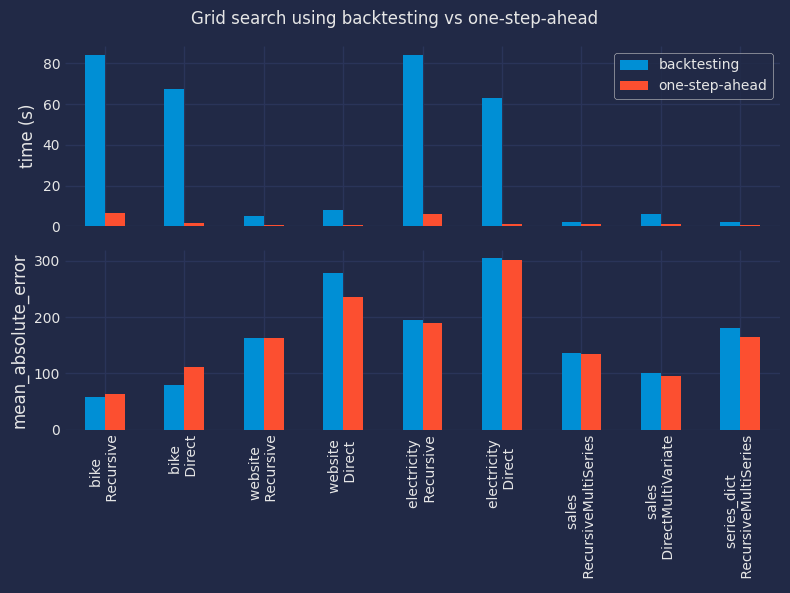

In [15]:
# Results
# ==============================================================================
summarize_results(
    results   = results_grid_search,
    metric    = metric,
    plot      = True,
    fig_size  = (8, 6),
    title     = 'Grid search using backtesting vs one-step-ahead',
    save_plot = "../img/grid_search_benchmarck.png"
)

### Bayesian search

In [28]:
# Table to store results
# ==============================================================================
results_bayesian_search = []
metric = 'mean_absolute_error'

In [29]:
# Dataset bike_sharing_extended_features - ForecasterRecursive
# ==============================================================================
end_train = '2012-03-31 23:59:00'
end_validation = '2012-08-31 23:59:00'
exog_features = [
    'month_sin', 'month_cos', 'week_of_year_sin', 'week_of_year_cos', 'week_day_sin',
    'week_day_cos', 'hour_day_sin', 'hour_day_cos', 'sunrise_hour_sin', 'sunrise_hour_cos',
    'sunset_hour_sin', 'sunset_hour_cos', 'holiday_previous_day', 'holiday_next_day',
    'temp_roll_mean_1_day', 'temp_roll_mean_7_day', 'temp_roll_max_1_day',
    'temp_roll_min_1_day', 'temp_roll_max_7_day', 'temp_roll_min_7_day',
    'temp', 'holiday'
]

forecaster = ForecasterRecursive(
                 regressor = LGBMRegressor(random_state=123, verbose=-1),
                 lags      = 10
             )

lags_grid = [48, 72, (1, 2, 3, 23, 24, 25, 167, 168, 169)]


def search_space(trial):
    search_space  = {
        'n_estimators' : trial.suggest_int('n_estimators', 400, 1200, step=100),
        'max_depth'    : trial.suggest_int('max_depth', 3, 10, step=1),
        'learning_rate': trial.suggest_float('learning_rate', 0.01, 1),
        'gamma'        : trial.suggest_float('gamma', 0, 1),
        'reg_alpha'    : trial.suggest_float('reg_alpha', 0, 1),
        'reg_lambda'   : trial.suggest_float('reg_lambda', 0, 1),
        'lags'         : trial.suggest_categorical('lags', lags_grid)
    }

    return search_space


time_1, time_2, metric_1, metric_2 = run_benchmark(
    data                    = data_bike,
    forecaster_to_benchmark = forecaster,
    search_method           = 'bayesian_search',
    search_space            = search_space,
    end_train               = end_train,
    end_validation          = end_validation,
    target                  = 'users',
    exog_features           = exog_features,
    steps                   = 24,
    metric                  = metric
)

results_bayesian_search.append([
    'bike_sharing',
    type(forecaster).__name__,
    time_1,
    time_2,
    metric_1,
    metric_2,
])

/home/ubuntu/anaconda3/envs/skforecast_14_py12/lib/python3.12/site-packages/skforecast/model_selection/_search.py:792: OneStepAheadValidationWarning: One-step-ahead predictions are used for faster model comparison, but they may not fully represent multi-step prediction performance. It is recommended to backtest the final model for a more accurate multi-step performance estimate. 
 You can suppress this warning using: warnings.simplefilter('ignore', category=OneStepAheadValidationWarning)
  warnings.warn(


-----------------
Benchmark results
-----------------
Execution time backtesting   : 87.29837822914124
Execution time one step ahead: 30.27300262451172
Same lags   : True
Same params : True

Method: backtesting
    lags   : [  1   2   3  23  24  25 167 168 169]
    params : {'n_estimators': 1200, 'max_depth': 10, 'learning_rate': 0.017833474222028703, 'gamma': 0.2285821738161964, 'reg_alpha': 0.2379772800670556, 'reg_lambda': 0.9887301767538853}
    mean_absolute_error: 55.80577702511616

Method: one step ahead
    lags   : [  1   2   3  23  24  25 167 168 169]
    params : {'n_estimators': 1200, 'max_depth': 10, 'learning_rate': 0.017833474222028703, 'gamma': 0.2285821738161964, 'reg_alpha': 0.2379772800670556, 'reg_lambda': 0.9887301767538853}
    mean_absolute_error: 55.80577702511616


In [30]:
# Dataset bike_sharing_extended_features - ForecasterDirect
# ==============================================================================
forecaster = ForecasterDirect(
                 regressor     = Ridge(random_state=123),
                 transformer_y = StandardScaler(),
                 steps         = 24,
                 lags          = 10
             )

lags_grid = [48, 72, (1, 2, 3, 23, 24, 25, 167, 168, 169)]


def search_space(trial):
    search_space  = {
        'alpha': trial.suggest_float('alpha', 0.001, 1000, log=True),
        'lags' : trial.suggest_categorical('lags', lags_grid)
    }

    return search_space


time_1, time_2, metric_1, metric_2 = run_benchmark(
    data                    = data_bike,
    forecaster_to_benchmark = forecaster,
    search_method           = 'bayesian_search',
    search_space            = search_space,
    end_train               = end_train,
    end_validation          = end_validation,
    target                  = 'users',
    exog_features           = exog_features,
    steps                   = 24,
    metric                  = metric
)

results_bayesian_search.append([
    'bike_sharing',
    type(forecaster).__name__,
    time_1,
    time_2,
    metric_1,
    metric_2,
])

/home/ubuntu/anaconda3/envs/skforecast_14_py12/lib/python3.12/site-packages/skforecast/model_selection/_search.py:792: OneStepAheadValidationWarning: One-step-ahead predictions are used for faster model comparison, but they may not fully represent multi-step prediction performance. It is recommended to backtest the final model for a more accurate multi-step performance estimate. 
 You can suppress this warning using: warnings.simplefilter('ignore', category=OneStepAheadValidationWarning)
  warnings.warn(


-----------------
Benchmark results
-----------------
Execution time backtesting   : 18.23356056213379
Execution time one step ahead: 1.1543662548065186
Same lags   : False
Same params : False

Method: backtesting
    lags   : [ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24
 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47 48
 49 50 51 52 53 54 55 56 57 58 59 60 61 62 63 64 65 66 67 68 69 70 71 72]
    params : {'alpha': 121.0898788312409}
    mean_absolute_error: 79.14983372140252

Method: one step ahead
    lags   : [  1   2   3  23  24  25 167 168 169]
    params : {'alpha': 15.094374246471325}
    mean_absolute_error: 111.96208734026862


In [31]:
# Dataset website_visits - ForecasterRecursive
# ==============================================================================
end_train = '2021-03-30 23:59:00'
end_validation = '2021-06-30 23:59:00'
exog_features = [col for col in data_website.columns if col.startswith(('month_', 'week_day_', 'month_day_'))]

forecaster = ForecasterRecursive(
                 regressor     = Ridge(random_state=123),
                 transformer_y = StandardScaler(),
                 lags          = 10
             )

lags_grid = [7, 14, 21, [7, 14, 21]]


def search_space(trial):
    search_space  = {
        'alpha': trial.suggest_float('alpha', 0.001, 1000, log=True),
        'lags' : trial.suggest_categorical('lags', lags_grid)
    } 
    
    return search_space


time_1, time_2, metric_1, metric_2 = run_benchmark(
    data                    = data_website,
    forecaster_to_benchmark = forecaster,
    search_method           = 'bayesian_search',
    search_space            = search_space,
    end_train               = end_train,
    end_validation          = end_validation,
    target                  = 'users',
    exog_features           = exog_features,
    steps                   = 7,
    metric                  = metric
)

results_bayesian_search.append([
    'website',
    type(forecaster).__name__,
    time_1,
    time_2,
    metric_1,
    metric_2,
])

/home/ubuntu/anaconda3/envs/skforecast_14_py12/lib/python3.12/site-packages/skforecast/model_selection/_search.py:792: OneStepAheadValidationWarning: One-step-ahead predictions are used for faster model comparison, but they may not fully represent multi-step prediction performance. It is recommended to backtest the final model for a more accurate multi-step performance estimate. 
 You can suppress this warning using: warnings.simplefilter('ignore', category=OneStepAheadValidationWarning)
  warnings.warn(


-----------------
Benchmark results
-----------------
Execution time backtesting   : 0.9961090087890625
Execution time one step ahead: 0.23384618759155273
Same lags   : False
Same params : False

Method: backtesting
    lags   : [ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21]
    params : {'alpha': 0.07474245141964296}
    mean_absolute_error: 136.76802274106487

Method: one step ahead
    lags   : [ 1  2  3  4  5  6  7  8  9 10 11 12 13 14]
    params : {'alpha': 0.03182234592129467}
    mean_absolute_error: 173.5282998809151


In [32]:
# Dataset website_visits - ForecasterDirect
# ==============================================================================
forecaster = ForecasterDirect(
                 regressor     = Ridge(random_state=123),
                 transformer_y = StandardScaler(),
                 lags          = 10,
                 steps         = 7
             )

lags_grid = [7, 14, 21, [7, 14, 21]]


def search_space(trial):
    search_space  = {
        'alpha': trial.suggest_float('alpha', 0.001, 1000, log=True),
        'lags' : trial.suggest_categorical('lags', lags_grid)
    } 
    
    return search_space


time_1, time_2, metric_1, metric_2 = run_benchmark(
    data                    = data_website,
    forecaster_to_benchmark = forecaster,
    search_method           = 'bayesian_search',
    search_space            = search_space,
    end_train               = end_train,
    end_validation          = end_validation,
    target                  = 'users',
    exog_features           = exog_features,
    steps                   = 7,
    metric                  = metric
)

results_bayesian_search.append([
    'website',
    type(forecaster).__name__,
    time_1,
    time_2,
    metric_1,
    metric_2,
])

/home/ubuntu/anaconda3/envs/skforecast_14_py12/lib/python3.12/site-packages/skforecast/model_selection/_search.py:792: OneStepAheadValidationWarning: One-step-ahead predictions are used for faster model comparison, but they may not fully represent multi-step prediction performance. It is recommended to backtest the final model for a more accurate multi-step performance estimate. 
 You can suppress this warning using: warnings.simplefilter('ignore', category=OneStepAheadValidationWarning)
  warnings.warn(


-----------------
Benchmark results
-----------------
Execution time backtesting   : 1.3789756298065186
Execution time one step ahead: 0.28351378440856934
Same lags   : False
Same params : False

Method: backtesting
    lags   : [ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21]
    params : {'alpha': 0.07474245141964296}
    mean_absolute_error: 139.40123604696387

Method: one step ahead
    lags   : [ 1  2  3  4  5  6  7  8  9 10 11 12 13 14]
    params : {'alpha': 0.03182234592129467}
    mean_absolute_error: 153.6723680506666


In [33]:
# Dataset vic_electricity - ForecasterRecursive
# ==============================================================================
end_train = '2013-06-30 23:59:00'
end_validation = '2013-11-30 23:59:00'
exog_features = ['Temperature', 'Holiday']

forecaster = ForecasterRecursive(
                 regressor = LGBMRegressor(random_state=123, verbose=-1),
                 lags      = 10
             )

lags_grid = [48, 72, (1, 2, 3, 23, 24, 25, 167, 168, 169)]


def search_space(trial):
    search_space  = {
        'n_estimators' : trial.suggest_int('n_estimators', 400, 1200, step=100),
        'max_depth'    : trial.suggest_int('max_depth', 3, 10, step=1),
        'learning_rate': trial.suggest_float('learning_rate', 0.01, 1),
        'gamma'        : trial.suggest_float('gamma', 0, 1),
        'reg_alpha'    : trial.suggest_float('reg_alpha', 0, 1),
        'reg_lambda'   : trial.suggest_float('reg_lambda', 0, 1),
        'lags'         : trial.suggest_categorical('lags', lags_grid)
    } 
    return search_space


time_1, time_2, metric_1, metric_2 = run_benchmark(
    data                    = data_electricity,
    forecaster_to_benchmark = forecaster,
    search_method           = 'bayesian_search',
    search_space            = search_space,
    end_train               = end_train,
    end_validation          = end_validation,
    target                  = 'Demand',
    exog_features           = exog_features,
    steps                   = 24,
    metric                  = metric
)

results_bayesian_search.append([
    'electricity',
    type(forecaster).__name__,
    time_1,
    time_2,
    metric_1,
    metric_2,
])

/home/ubuntu/anaconda3/envs/skforecast_14_py12/lib/python3.12/site-packages/skforecast/model_selection/_search.py:792: OneStepAheadValidationWarning: One-step-ahead predictions are used for faster model comparison, but they may not fully represent multi-step prediction performance. It is recommended to backtest the final model for a more accurate multi-step performance estimate. 
 You can suppress this warning using: warnings.simplefilter('ignore', category=OneStepAheadValidationWarning)
  warnings.warn(


-----------------
Benchmark results
-----------------
Execution time backtesting   : 87.99208378791809
Execution time one step ahead: 27.090394020080566
Same lags   : False
Same params : False

Method: backtesting
    lags   : [ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24
 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47 48
 49 50 51 52 53 54 55 56 57 58 59 60 61 62 63 64 65 66 67 68 69 70 71 72]
    params : {'n_estimators': 1200, 'max_depth': 8, 'learning_rate': 0.020288327487155415, 'gamma': 0.9893221948178936, 'reg_alpha': 0.0026751307734329544, 'reg_lambda': 0.0033431281459104997}
    mean_absolute_error: 196.74829952595292

Method: one step ahead
    lags   : [  1   2   3  23  24  25 167 168 169]
    params : {'n_estimators': 1200, 'max_depth': 10, 'learning_rate': 0.056896300053531614, 'gamma': 0.2725691628660212, 'reg_alpha': 0.24605588251006993, 'reg_lambda': 0.9687485406819449}
    mean_absolute_error: 191.37491441780287


In [34]:
# Dataset vic_electricity - ForecasterDirect
# ==============================================================================
forecaster = ForecasterDirect(
                 regressor     = Ridge(random_state=123),
                 transformer_y = StandardScaler(),
                 lags          = 10,
                 steps         = 24
             )

lags_grid = (48, 72, (1, 2, 3, 23, 24, 25, 167, 168, 169))


def search_space(trial):
    search_space  = {
        'alpha': trial.suggest_float('alpha', 0.001, 1000, log=True),
        'lags' : trial.suggest_categorical('lags', lags_grid)
    }

    return search_space


time_1, time_2, metric_1, metric_2 = run_benchmark(
    data                    = data_electricity,
    forecaster_to_benchmark = forecaster,
    search_method           = 'bayesian_search',
    search_space            = search_space,
    end_train               = end_train,
    end_validation          = end_validation,
    target                  = 'Demand',
    exog_features           = exog_features,
    steps                   = 24,
    metric                  = metric
)

results_bayesian_search.append([
    'electricity',
    type(forecaster).__name__,
    time_1,
    time_2,
    metric_1,
    metric_2,
])

/home/ubuntu/anaconda3/envs/skforecast_14_py12/lib/python3.12/site-packages/optuna/distributions.py:524: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains (1, 2, 3, 23, 24, 25, 167, 168, 169) which is of type tuple.
  warnings.warn(message)
/home/ubuntu/anaconda3/envs/skforecast_14_py12/lib/python3.12/site-packages/optuna/distributions.py:524: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains (1, 2, 3, 23, 24, 25, 167, 168, 169) which is of type tuple.
  warnings.warn(message)
/home/ubuntu/anaconda3/envs/skforecast_14_py12/lib/python3.12/site-packages/optuna/distributions.py:524: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains (1, 2, 3, 23, 24, 25, 167, 168, 169) which is of type tuple.
  warnings.warn(message)
/home/u

-----------------
Benchmark results
-----------------
Execution time backtesting   : 17.02194857597351
Execution time one step ahead: 0.7432243824005127
Same lags   : True
Same params : False

Method: backtesting
    lags   : [ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24
 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47 48
 49 50 51 52 53 54 55 56 57 58 59 60 61 62 63 64 65 66 67 68 69 70 71 72]
    params : {'alpha': 16.432489069228232}
    mean_absolute_error: 307.133652786205

Method: one step ahead
    lags   : [ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24
 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47 48
 49 50 51 52 53 54 55 56 57 58 59 60 61 62 63 64 65 66 67 68 69 70 71 72]
    params : {'alpha': 0.36149961722510493}
    mean_absolute_error: 300.87028133154695


In [35]:
# Dataset sales - ForecasterRecursiveMultiSeries
# ==============================================================================
end_train = '2014-05-15 23:59:00'
end_validation = '2014-07-15 23:59:00'
levels = ['item_1', 'item_2', 'item_3']
exog_features = ['day_of_week']

forecaster = ForecasterRecursiveMultiSeries(
                 regressor          = LGBMRegressor(random_state=123, verbose=-1),
                 lags               = 24,
                 encoding           = "ordinal",
                 transformer_series = None,
                 transformer_exog   = None,
                 weight_func        = None,
                 series_weights     = None,
                 differentiation    = None,
                 dropna_from_series = False,
                 fit_kwargs         = None,
                 forecaster_id      = None
             )

lags_grid = [48, 72]


def search_space(trial):
    search_space  = {
        'n_estimators' : trial.suggest_int('n_estimators', 50, 200),
        'max_depth'    : trial.suggest_int('max_depth', 3, 10, step=1),
        'learning_rate': trial.suggest_float('learning_rate', 0.01, 1),
        'lags'         : trial.suggest_categorical('lags', lags_grid)
    } 
    return search_space


time_1, time_2, metric_1, metric_2 = run_benchmark_multiseries(
    data                    = data_sales,
    forecaster_to_benchmark = forecaster,
    search_method           = 'bayesian_search',
    search_space            = search_space,
    end_train               = end_train,
    end_validation          = end_validation,
    levels                  = levels,
    exog_features           = exog_features,
    steps                   = 36,
    metric                  = metric
)

results_bayesian_search.append([
    'sales',
    type(forecaster).__name__,
    time_1,
    time_2,
    metric_1,
    metric_2,
])

/home/ubuntu/anaconda3/envs/skforecast_14_py12/lib/python3.12/site-packages/skforecast/model_selection/_search.py:1826: OneStepAheadValidationWarning: One-step-ahead predictions are used for faster model comparison, but they may not fully represent multi-step prediction performance. It is recommended to backtest the final model for a more accurate multi-step performance estimate. 
 You can suppress this warning using: warnings.simplefilter('ignore', category=OneStepAheadValidationWarning)
  warnings.warn(


Benchmark results
-----------------
Execution time backtesting   : 3.9293558597564697
Execution time one step ahead: 3.1049904823303223
Same lags   : True
Same params : False

Method: backtesting
    lags   : [ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24
 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47 48]
    params : {'n_estimators': 199, 'max_depth': 3, 'learning_rate': 0.01901626315047264}
    135.45451272241843

Method: one step ahead
    lags   : [ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24
 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47 48]
    params : {'n_estimators': 198, 'max_depth': 3, 'learning_rate': 0.06045266837878549}
    123.59899056676193


In [36]:
# Dataset sales - ForecasterDirectMultiVariate
# ==============================================================================
forecaster = ForecasterDirectMultiVariate(
                 regressor          = LGBMRegressor(random_state=123, verbose=-1),
                 lags               = 24,
                 steps              = 5,
                 level              = 'item_1',
                 transformer_series = None,
                 transformer_exog   = None,
                 weight_func        = None,
                 fit_kwargs         = None,
                 forecaster_id      = None
             )

lags_grid = [48, 72]


def search_space(trial):
    search_space  = {
        'n_estimators' : trial.suggest_int('n_estimators', 50, 200),
        'max_depth'    : trial.suggest_int('max_depth', 3, 10, step=1),
        'learning_rate': trial.suggest_float('learning_rate', 0.01, 1),
        'lags'         : trial.suggest_categorical('lags', lags_grid)
    }

    return search_space


time_1, time_2, metric_1, metric_2 = run_benchmark_multiseries(
    data                    = data_sales,
    forecaster_to_benchmark = forecaster,
    search_method           = 'bayesian_search',
    search_space            = search_space,
    end_train               = end_train,
    end_validation          = end_validation,
    levels                  = levels,
    exog_features           = exog_features,
    steps                   = 5,
    metric                  = metric
)

results_bayesian_search.append([
    'sales',
    type(forecaster).__name__,
    time_1,
    time_2,
    metric_1,
    metric_2,
])

/home/ubuntu/anaconda3/envs/skforecast_14_py12/lib/python3.12/site-packages/skforecast/model_selection/_utils.py:470: IgnoredArgumentWarning: `levels` argument have no use when the forecaster is of type `ForecasterDirectMultiVariate`. The level of this forecaster is 'item_1', to predict another level, change the `level` argument when initializing the forecaster. 
 
 You can suppress this warning using: warnings.simplefilter('ignore', category=IgnoredArgumentWarning)
  warnings.warn(
/home/ubuntu/anaconda3/envs/skforecast_14_py12/lib/python3.12/site-packages/skforecast/model_selection/_utils.py:470: IgnoredArgumentWarning: `levels` argument have no use when the forecaster is of type `ForecasterDirectMultiVariate`. The level of this forecaster is 'item_1', to predict another level, change the `level` argument when initializing the forecaster. 
 
 You can suppress this warning using: warnings.simplefilter('ignore', category=IgnoredArgumentWarning)
  warnings.warn(
/home/ubuntu/anaconda3/e

Benchmark results
-----------------
Execution time backtesting   : 14.083634376525879
Execution time one step ahead: 3.38277268409729
Same lags   : False
Same params : False

Method: backtesting
    lags   : [ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24
 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47 48]
    params : {'n_estimators': 178, 'max_depth': 4, 'learning_rate': 0.029392307095288957}
    98.66981600939468

Method: one step ahead
    lags   : [ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24
 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47 48
 49 50 51 52 53 54 55 56 57 58 59 60 61 62 63 64 65 66 67 68 69 70 71 72]
    params : {'n_estimators': 98, 'max_depth': 5, 'learning_rate': 0.23598059857016607}
    101.07276932380157


In [38]:
# Dataset series_dict - ForecasterRecursiveMultiSeries
# ==============================================================================
end_train = '2016-05-31 23:59:00'
end_validation = '2016-07-31 23:59:00'
levels = ['id_1000', 'id_1001', 'id_1002', 'id_1003', 'id_1004']
series_dict_train = {k: v.loc[: end_train,] for k, v in series_dict.items()}
exog_dict_train   = {k: v.loc[: end_train,] for k, v in exog_dict.items()}
series_dict_test  = {k: v.loc[end_train:,] for k, v in series_dict.items()}
exog_dict_test    = {k: v.loc[end_train:,] for k, v in exog_dict.items()}

forecaster_to_benchmark = ForecasterRecursiveMultiSeries(
                 regressor          = LGBMRegressor(random_state=123, verbose=-1),
                 lags               = 24,
                 encoding           = "ordinal",
                 transformer_series = None,
                 transformer_exog   = None,
                 weight_func        = None,
                 series_weights     = None,
                 differentiation    = None,
                 dropna_from_series = False,
                 fit_kwargs         = None,
                 forecaster_id      = None
             )


def search_space(trial):
    search_space  = {
        'n_estimators': trial.suggest_int('n_estimators', 50, 200),
        'max_depth'   : trial.suggest_int('max_depth', 3, 7, step=1),
        'lags'        : trial.suggest_categorical('lags', [7, 14])
    } 
    return search_space


# Backtesting
forecaster = copy(forecaster_to_benchmark)
cv = TimeSeriesFold(
        initial_train_size = 100,
        steps              = 24,
        refit              = False,
     )
start  = time()
results_1, _ = bayesian_search_forecaster_multiseries(
                   forecaster         = forecaster,
                   series             = {k: v.loc[: end_validation,] for k, v in series_dict.items()},
                   exog               = {k: v.loc[: end_validation,] for k, v in exog_dict.items()},
                   cv                 = cv,
                   search_space       = search_space,
                   n_trials           = 10,
                   metric             = metric,
                   return_best        = False,
                   n_jobs             = 'auto',
                   verbose            = False,
                   show_progress      = False,
                   suppress_warnings  = True
               )
end = time()
time_1 = end - start
best_params = results_1.loc[0, 'params']
best_lags = results_1.loc[0, 'lags']
forecaster.set_params(best_params)
forecaster.set_lags(lags=best_lags)

cv = TimeSeriesFold(
        initial_train_size = 213,
        steps              = 24,
        refit              = False,
     )
metric_1, pred_1 = backtesting_forecaster_multiseries(
                       forecaster         = forecaster,
                       series             = series_dict,
                       exog               = exog_dict,
                       cv                 = cv,
                       levels             = levels,
                       metric             = metric,
                       verbose            = False,
                       show_progress      = False,
                       suppress_warnings  = True
                   )

# One step ahead
forecaster = copy(forecaster_to_benchmark)
cv = OneStepAheadFold(initial_train_size = 100)
start  = time()
results_2, _ = bayesian_search_forecaster_multiseries(
                   forecaster         = forecaster,
                   series             = {k: v.loc[: end_validation,] for k, v in series_dict.items()},
                   exog               = {k: v.loc[: end_validation,] for k, v in exog_dict.items()},
                   cv                 = cv,
                   levels             = levels,
                   search_space       = search_space,
                   n_trials           = 10,
                   metric             = metric,
                   return_best        = False,
                   verbose            = False,
                   show_progress      = False,
                   suppress_warnings  = True
               )
end = time()
time_2 = end - start
best_params = results_2.loc[0, 'params']
best_lags = results_2.loc[0, 'lags']
forecaster.set_params(best_params)
forecaster.set_lags(lags=best_lags)

cv = TimeSeriesFold(
        initial_train_size = 213,
        steps              = 24,
        refit              = False,
     )
metric_2, pred_2 = backtesting_forecaster_multiseries(
                       forecaster         = forecaster,
                       series             = series_dict,
                       exog               = exog_dict,
                       cv                 = cv,
                       levels             = levels,
                       metric             = metric,
                       verbose            = False,
                       show_progress      = False,
                       suppress_warnings  = True
                   )

print("Benchmark results")
print("-----------------")
print('Execution time backtesting   :', time_1)
print('Execution time one step ahead:', time_2)
print(f"Same lags   : {np.array_equal(results_1.loc[0, 'lags'], results_2.loc[0, 'lags'])}")
print(f"Same params : {results_1.loc[0, 'params'] == results_2.loc[0, 'params']}")
print("")
print("Method: backtesting")
print(f"    lags   : {results_1.loc[0, 'lags']}")
print(f"    params : {results_1.loc[0, 'params']}")
print(f"    {metric_1.loc[0, metric]}")
print("")
print("Method: one step ahead")
print(f"    lags   : {results_2.loc[0, 'lags']}")
print(f"    params : {results_2.loc[0, 'params']}")
print(f"    {metric_2.loc[0, metric]}")

results_bayesian_search.append([
    'series_dict',
    type(forecaster).__name__,
    time_1,
    time_2,
    metric_1.loc[0, metric],
    metric_2.loc[0, metric],
])

Benchmark results
-----------------
Execution time backtesting   : 2.4853312969207764
Execution time one step ahead: 0.9899699687957764
Same lags   : True
Same params : True

Method: backtesting
    lags   : [ 1  2  3  4  5  6  7  8  9 10 11 12 13 14]
    params : {'n_estimators': 77, 'max_depth': 3}
    208.60243551060555

Method: one step ahead
    lags   : [ 1  2  3  4  5  6  7  8  9 10 11 12 13 14]
    params : {'n_estimators': 77, 'max_depth': 3}
    208.60243551060555


,dataset,forecaster,time_search_backtesting,time_search_one_step,metric_backtesting,metric_one_step,ratio_speed,ratio_metric,dataset_forecaster
0,bike_sharing,ForecasterRecursive,87.298378,30.273003,55.805777,55.805777,2.88,1.00,bike_sharing \n Recursive
1,bike_sharing,ForecasterDirect,18.233561,1.154366,79.149834,111.962087,15.80,0.71,bike_sharing \n Direct
2,website,ForecasterRecursive,0.996109,0.233846,136.768023,173.528300,4.26,0.79,website \n Recursive
3,website,ForecasterDirect,1.378976,0.283514,139.401236,153.672368,4.86,0.91,website \n Direct
4,electricity,ForecasterRecursive,87.992084,27.090394,196.748300,191.374914,3.25,1.03,electricity \n Recursive
5,electricity,ForecasterDirect,17.021949,0.743224,307.133653,300.870281,22.90,1.02,electricity \n Direct
6,sales,ForecasterRecursiveMultiSeries,3.929356,3.104990,135.454513,123.598991,1.27,1.10,sales \n RecursiveMultiSeries
7,sales,ForecasterDirectMultiVariate,14.083634,3.382773,98.669816,101.072769,4.16,0.98,sales \n DirectMultiVariate
8,series_dict,ForecasterRecursiveMultiSeries,2.485331,0.989970,208.602436,208.602436,2.51,1.00,series_dict \n RecursiveMultiSeries


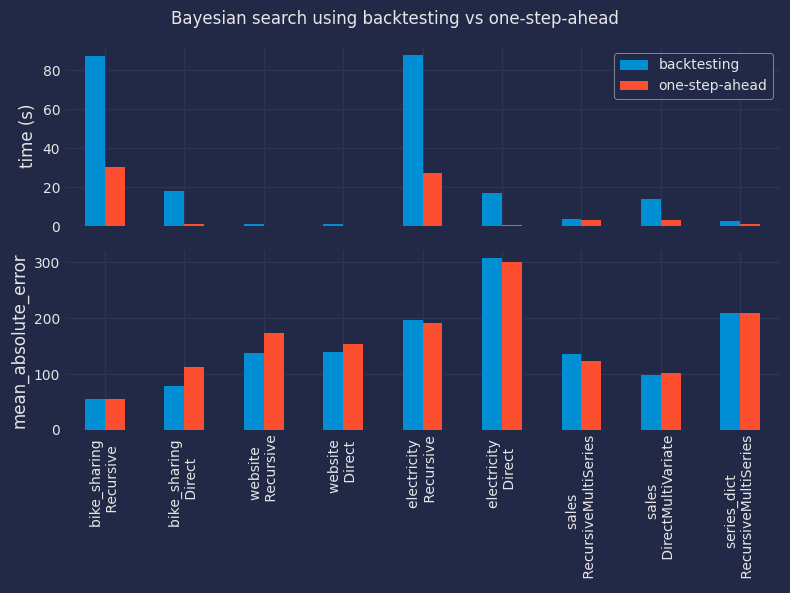

In [39]:
# Results
# ==============================================================================
summarize_results(
    results   = results_bayesian_search,
    metric    = metric,
    plot      = True,
    fig_size  = (8, 6),
    title     = 'Bayesian search using backtesting vs one-step-ahead',
    save_plot = "../img/bayesian_search_benchmarck.png"
)